# Τεχνικές Εξόρυξης Δεδομένων Εργασία εαρινού εξαμήνου 2024-25
Καραγιώργος Παύλος 1115202200062\
Μαλχάζος Άγγελος Νικόλαος 1115202200091\
Μούτη Σεμέλη-Γεωργία 1115202200102



Το word embedding που χρησιμοποιείται όπου χρειάζεται word2vec είναι το GoogleNews-vectors-negative300 (https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300)



# **Part 1 Pre-Processing**

### Task 1: Data Exploration and Feature Engineering

In [1]:
%pip install datasets
%pip install scikit-learn
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import libraries

In [2]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import string
from itertools import islice
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Download necessary nltk datasets
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

/home/aggelos/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aggelos/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/aggelos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aggelos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/aggelos/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# define columns of interest
columns_of_interest_meta = ['main_category','title','average_rating','rating_number','features','description','price','parent_asin']
columns_of_interest_reviews = ['rating','title','text','parent_asin','timestamp','user_id']

Getting the data

In [4]:
# load and filter meta datasets using select columns
electronics_meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Electronics", split='full', streaming=True).select_columns(columns_of_interest_meta)
beauty_meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Beauty_and_Personal_Care", split='full', streaming=True).select_columns(columns_of_interest_meta)
books_meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Books", split='full', streaming=True).select_columns(columns_of_interest_meta)
home_kitchen_meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Home_and_Kitchen", split='full', streaming=True).select_columns(columns_of_interest_meta)
musical_instruments_meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Musical_Instruments", split='full', streaming=True).select_columns(columns_of_interest_meta)

# load and filter review datasets using select columns
electronics_reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Electronics", split='full', streaming=True).select_columns(columns_of_interest_reviews)
beauty_reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Beauty_and_Personal_Care", split='full', streaming=True).select_columns(columns_of_interest_reviews)
books_reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Books", split='full', streaming=True).select_columns(columns_of_interest_reviews)
home_kitchen_reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Home_and_Kitchen", split='full', streaming=True).select_columns(columns_of_interest_reviews)
musical_instruments_reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Musical_Instruments", split='full', streaming=True).select_columns(columns_of_interest_reviews)



Pre-Processing

Task1 Q1:

In [5]:
# initialize list to store all meta DataFrames
all_meta_dfs = []
all_reviews_dfs = []    

In [6]:
import re
import html
%pip install emoji

import emoji

def process_text(text, stem=0):
    import string
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer

    if not isinstance(text, str):
        return ""
    
    #remove html entities, html tags, usernames, URLs, replace emojis with whitespace
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = emoji.replace_emoji(text, replace='')
    
    # lowercase, strip, remove punctuation
    text = text.lower().strip().translate(str.maketrans("", "", string.punctuation))

    # tokenize
    tokens = nltk.word_tokenize(text)

    # remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # stemming (used in part 2)
    if stem == 1:
        stemmer = PorterStemmer()
        filtered_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return " ".join(filtered_tokens)

Note: you may need to restart the kernel to use updated packages.


In [7]:
def process_category(meta_data, reviews_data, category_name, sample_size=20000):
    """Process meta and reviews data for a given category."""

    # Take a sample of 10.000 records
    df_meta = pd.DataFrame(islice(meta_data, sample_size))
    df_reviews = pd.DataFrame(islice(reviews_data, sample_size))

    # Filter reviews where parent_asin matches any asin in meta
    if 'parent_asin' in df_reviews.columns and 'parent_asin' in df_meta.columns:
        valid_asins = set(df_meta['parent_asin'])
        df_reviews = df_reviews[df_reviews['parent_asin'].isin(valid_asins)]

    # clean price
    df_meta["price"] = (
        pd.to_numeric(df_meta["price"], errors='coerce')
        .replace([np.inf, -np.inf], np.nan)
        .fillna(-1)
        .round()
        .astype(int)
    )

    # handle main_category missing value
    if 'main_category' not in df_meta.columns or df_meta['main_category'].isnull().all():
        df_meta['main_category'] = category_name
    else:
        df_meta['main_category'] = df_meta['main_category'].fillna(category_name)
        df_meta['main_category'] = df_meta['main_category'].replace('', category_name)

    # preprocess text fields
    for col in ['title', 'text']:
        if col in df_reviews.columns:
            df_reviews[col] = df_reviews[col].apply(process_text)

    # save to CSV format
    category_filename = category_name.lower().replace(' ', '_')
    df_meta.to_csv(f"{category_filename}_meta_sample.csv", index=False)
    df_reviews.to_csv(f"{category_filename}_reviews_sample.csv", index=False)

    return df_meta, df_reviews


In [8]:
# call function for all categories and collect meta DataFrames
categories = {
    "Electronics": (electronics_meta, electronics_reviews),
    "Beauty and Personal Care": (beauty_meta, beauty_reviews),
    "Books": (books_meta, books_reviews),
    "Home and Kitchen": (home_kitchen_meta, home_kitchen_reviews),
    "Musical Instruments": (musical_instruments_meta, musical_instruments_reviews)
}

for category_name, (meta, reviews) in categories.items():
    print(f"Processing {category_name}...")
    df_meta, df_review = process_category(meta, reviews, category_name)
    print(df_meta.head(1))
    print(df_review.head(1))
    all_meta_dfs.append(df_meta)
    all_reviews_dfs.append(df_review)

Processing Electronics...
     main_category                                   title  average_rating  \
0  All Electronics  FS-1051 FATSHARK TELEPORTER V3 HEADSET             3.5   

   rating_number features                                        description  \
0              6       []  [Teleporter V3 The “Teleporter V3” kit sets a ...   

   price parent_asin  
0     -1  B00MCW7G9M  
    rating                         title  \
27     4.0  anyone use recessed tv mount   

                                                 text parent_asin  \
27  believe electrical boxes made especially fit r...  B0862W5BQ8   

        timestamp                       user_id  
27  1484481615000  AEVWAM3YWN5URJVJIZZ6XPD2MKIA  
Processing Beauty and Personal Care...
  main_category                                              title  \
0    All Beauty  Shiyeen 10 Colors Hair Chalk for Girls Gift, K...   

   average_rating  rating_number  \
0             3.9             57   

                             

In [9]:

# combine all meta DataFrames
combined_meta = pd.concat(all_meta_dfs)

# calculate rating statistics
rating_stats = combined_meta.groupby('main_category')['average_rating'].agg(
    ['mean', 'median', 'count', 'std']
).sort_values('mean', ascending=False)

print("\nRating Statistics Across Categories:")
print(rating_stats)


Rating Statistics Across Categories:
                                  mean  median  count       std
main_category                                                  
Digital Music                 4.750000    4.75      4  0.208167
Movies & TV                   4.616667    4.75      6  0.483391
Handmade                      4.515385    4.70     65  0.649093
Home and Kitchen              4.432136    4.60    529  0.643696
Books                         4.412925    4.50  18189  0.564808
Apple Products                4.400000    4.60     22  0.624118
Beauty and Personal Care      4.370602    4.50    415  0.647517
Audible Audiobooks            4.365849    4.40    489  0.385388
Pet Supplies                  4.352174    4.50     46  0.581087
Amazon Fire TV                4.350000    4.35      2  0.212132
Premium Beauty                4.297055    4.40    713  0.443625
Industrial & Scientific       4.276678    4.50   1415  0.685282
Arts, Crafts & Sewing         4.276398    4.40    161  0.724009
Bu

In [10]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_22417/488912653.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


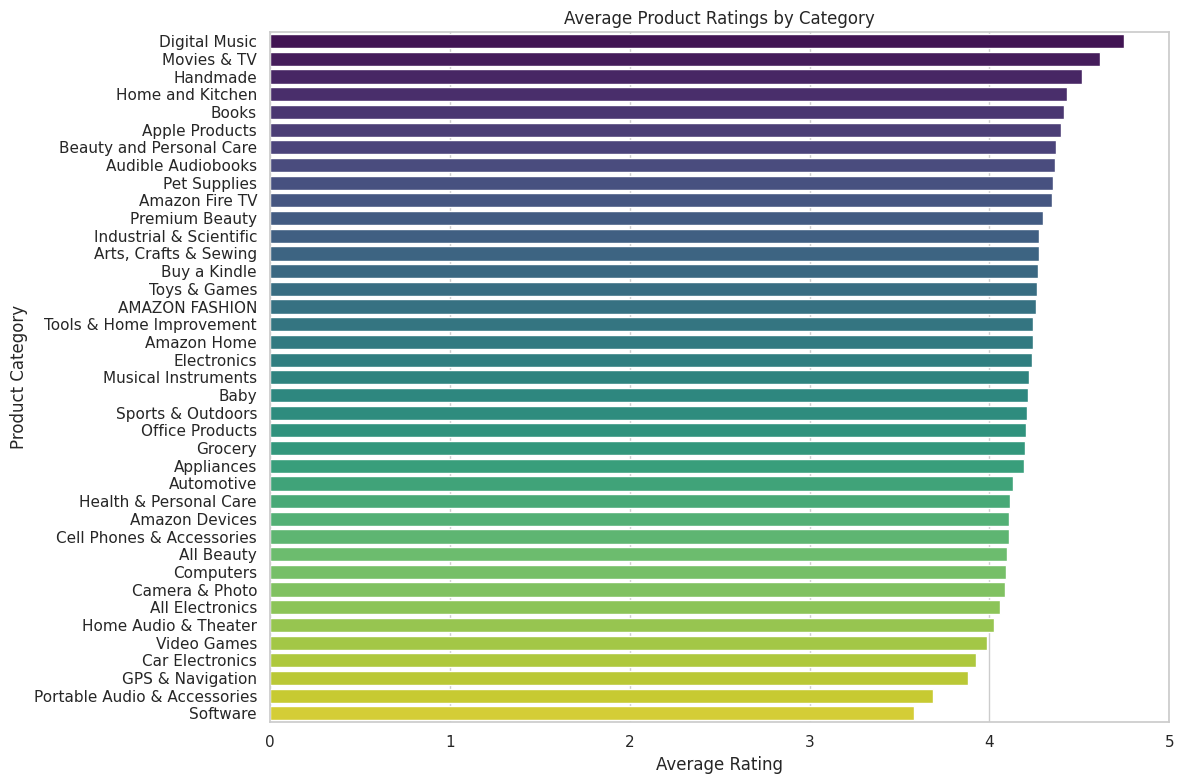

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# set seaborn style
sns.set(style="whitegrid")

# sort by average rating based on mean
rating_stats_sorted = rating_stats.sort_values("mean", ascending=False)

# plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x=rating_stats_sorted["mean"],
    y=rating_stats_sorted.index,
    palette="viridis"
)

# labels and title
plt.xlabel("Average Rating")
plt.ylabel("Product Category")
plt.title("Average Product Ratings by Category")
plt.xlim(0, 5)  

plt.tight_layout()
plt.show()

Task1 Q2: High number of reviews but low rated products common keywords

In [12]:
# combine all metadata and review DataFrames
df_meta_all = pd.concat(all_meta_dfs, ignore_index=True)
df_reviews_all = pd.concat(all_reviews_dfs, ignore_index=True)
print(len(df_meta_all))
print(len(df_reviews_all))


# merge on 'asin'
merged_df = pd.merge(df_reviews_all, df_meta_all, on='parent_asin', how='left')

print(f"Merged dataset has {merged_df.shape[0]} reviews.")
print(merged_df[['rating', 'parent_asin', 'text']])

100000
6877
Merged dataset has 6877 reviews.
      rating parent_asin                                               text
0        4.0  B0862W5BQ8  believe electrical boxes made especially fit r...
1        1.0  B07VV6TT69  waste money useful plane really anywhere short...
2        5.0  B07BJ8KD6X                     love fits chromebook perfectly
3        5.0  B009RUZ7TS          perfect condition would recommend anybody
4        1.0  B09V28P31X  set easy video pretty good paid year cam plus ...
...      ...         ...                                                ...
6872     2.0  B0B4SGJRHR                works great first one never arrived
6873     2.0  B00LCY77NG                                           returned
6874     5.0  B071VN1573                                         works good
6875     5.0  B0BLYVN162                                               play
6876     2.0  B07FDWWKWH                                              tight

[6877 rows x 3 columns]


In [13]:
# group by product
review_stats = (merged_df
                .groupby('parent_asin', as_index=False)
                .agg(
                    review_count   = ('parent_asin','size'),
                    average_rating = ('rating', 'mean')
                    )
)

# filter for problematic products
min_reviews = 5
max_avg_rating = 4

problematic = review_stats[
    (review_stats['review_count'] > min_reviews) &
    (review_stats['average_rating'] < max_avg_rating)
]

print(f"Found {len(problematic)} products with >{min_reviews} reviews and rating <{max_avg_rating}")

Found 20 products with >5 reviews and rating <4


In [14]:
# filter merged dataset
bad_reviews = merged_df[merged_df['parent_asin'].isin(problematic['parent_asin'])]

print(f"Collected {len(bad_reviews)} reviews from highly reviewed low rated products.")
bad_reviews[['parent_asin', 'title_x', 'rating', 'text']].head()


Collected 181 reviews from highly reviewed low rated products.


,parent_asin,title_x,rating,text
758,B07YT2VKTG,buy,5.0,best concealer ’ ever used love moisturizing e...
775,B0BQPCJBQD,great matte lipstick lasts day,4.0,great long lasting lipstick rated four star si...
801,B0BQPCJBQD,matte lipstick,3.0,little bit cakey lasts around 46 hours eating ...
816,B08DDDL6W7,body mist,5.0,spray
822,B07YT2VKTG,waste money,1.0,used twice came total waste money


In [15]:
# prepare text data
text_corpus = bad_reviews['text'].dropna().astype(str).values

# vectorizer for unigrams (phrases that only have 1 word)
vectorizer_uni = CountVectorizer(stop_words='english', max_features=25, ngram_range=(1, 1))
X_uni = vectorizer_uni.fit_transform(text_corpus)
uni_freq = list(zip(vectorizer_uni.get_feature_names_out(), X_uni.sum(axis=0).tolist()[0]))
top_unigrams = sorted(uni_freq, key=lambda x: x[1], reverse=True)

# vectorizer for bigrams (phrases with 2 words)
vectorizer_bi = CountVectorizer(stop_words='english', max_features=25, ngram_range=(2, 2))
X_bi = vectorizer_bi.fit_transform(text_corpus)
bi_freq = list(zip(vectorizer_bi.get_feature_names_out(), X_bi.sum(axis=0).tolist()[0]))
top_bigrams = sorted(bi_freq, key=lambda x: x[1], reverse=True)

# print top results
print("Top 20 unigrams:")
for word, freq in top_unigrams[:20]:
    print(f"  {word}: {freq}")

print("\nTop 20 bigrams:")
for phrase, freq in top_bigrams[:20]:
    print(f"  {phrase}: {freq}")


Top 20 unigrams:
  guitar: 61
  like: 44
  use: 41
  great: 39
  strings: 38
  quality: 33
  good: 31
  sound: 30
  price: 27
  product: 26
  im: 25
  really: 25
  violin: 25
  bought: 24
  tried: 24
  ive: 23
  easy: 22
  got: 21
  little: 21
  set: 21

Top 20 bigrams:
  sound quality: 6
  ive tried: 5
  easy apply: 4
  easy use: 4
  feel like: 4
  good quality: 4
  ive used: 4
  poor quality: 4
  tone generator: 4
  year old: 4
  12 hours: 3
  acoustic guitar: 3
  battery life: 3
  doesnt work: 3
  dont need: 3
  easy set: 3
  finger picks: 3
  im sure: 3
  make sure: 3
  music stand: 3


Visualise using wordcloud

In [16]:
%pip install wordcloud matplotlib

Note: you may need to restart the kernel to use updated packages.


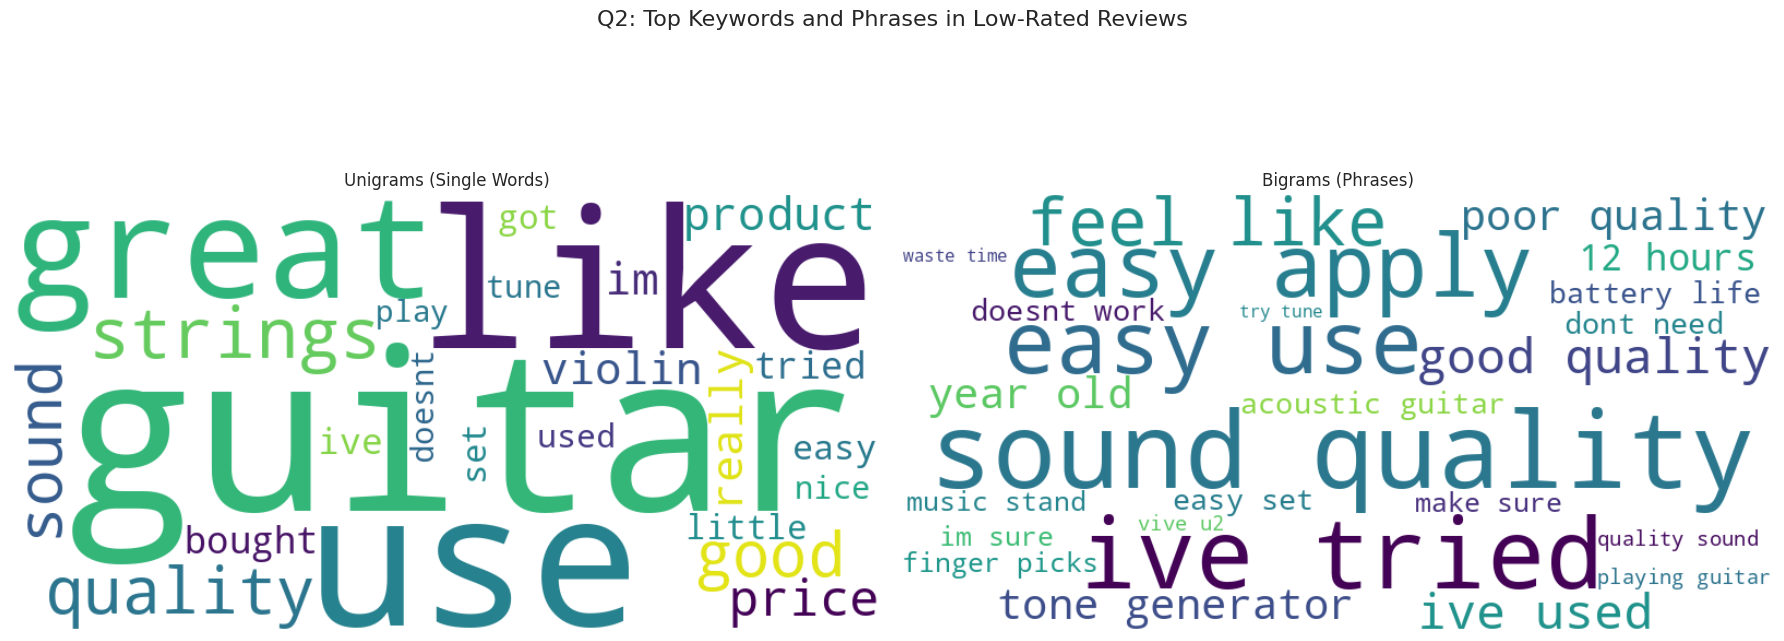

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# convert to frequency dictionaries
unigram_dict = dict(top_unigrams)
bigram_dict = dict(top_bigrams)

# create word clouds
wordcloud_uni = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigram_dict)
wordcloud_bi = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_dict)

# plot
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# unigrams
axs[0].imshow(wordcloud_uni, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title("Unigrams (Single Words)")

# bigrams
axs[1].imshow(wordcloud_bi, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title("Bigrams (Phrases)")

plt.suptitle("Q2: Top Keywords and Phrases in Low-Rated Reviews", fontsize=16)
plt.tight_layout()
plt.show()

Top 5 selling products

In [18]:
#top 5 selling products

def top5_best_sellers(categories_csv):
    dfs_reviews = []
    dfs_meta = []
    for category_name, (review_csv, meta_csv) in categories_csv.items():
        #load reviews in a list
        df_r = pd.read_csv(review_csv, usecols=["parent_asin","rating"])
        df_r['category'] = category_name
        dfs_reviews.append(df_r)

        #load meta in another list
        df_m = pd.read_csv(meta_csv, usecols=['parent_asin','title','features'])
        dfs_meta.append(df_m)

    #concat the lists into 2 dataframes
    all_reviews = pd.concat(dfs_reviews, ignore_index=True)
    all_meta    = pd.concat(dfs_meta, ignore_index=True).drop_duplicates('parent_asin')

    counts = (
        all_reviews
         .groupby(['parent_asin','category'], as_index=False)
         .agg(
            review_count   = ('parent_asin','size'),
            average_rating = ('rating', 'mean')
         )
    )

    counts = counts.sort_values(
        by=['review_count','average_rating'], ascending=[False, False]
    )
    top5 = counts.head(5)
    top5 = top5.merge(all_meta, on='parent_asin', how='left')

    top5['average_rating']     = top5['average_rating'].round(2)

    top5 = top5[[
        'parent_asin','category','review_count','average_rating','title', 'features'
    ]]


    return top5


Top 5 best-selling products:



,parent_asin,category,review_count,average_rating,title,features
0,B09W4F2X6S,Musical Instruments,40,4.32,"BONAOK Wireless Bluetooth Karaoke Microphone, ...",['【PARTICULAR DESIGN】 - The excellent design o...
1,B0BPJ4Q6FJ,Musical Instruments,32,4.78,D'Addario Guitar Strings - XL Nickel Electric ...,['BESTSELLING SET –\xa0XL Nickel are our best-...
2,B0BKZ3GCGR,Musical Instruments,31,4.58,D'Addario Celluloid Guitar Picks - 10 Pack - G...,['LIGHT GUITAR PICK: Light gauge (50mm) ideal ...
3,B0BTC9YJ2W,Musical Instruments,31,4.52,D'Addario Guitar Strings - Phosphor Bronze Aco...,"['CORROSION-RESISTANT, PRECISION WOUND –\xa0D’..."
4,B07S764D9V,Electronics,31,4.06,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",['The RP-TCM125 ErgoFit Earbud Headphones with...


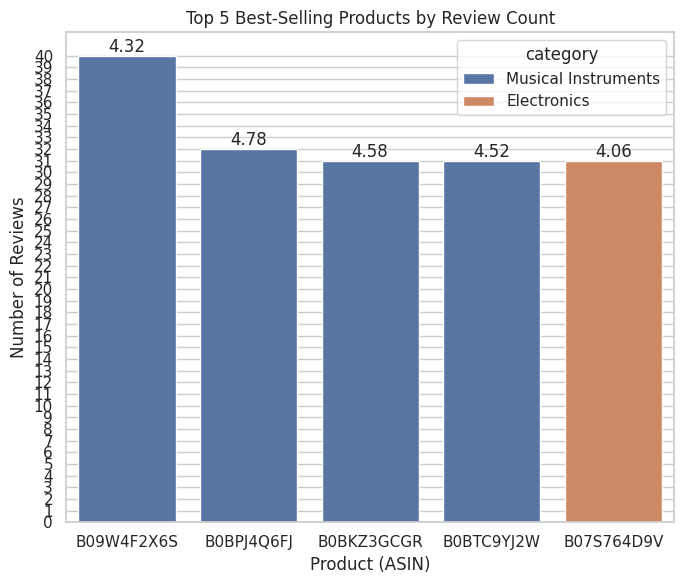

In [19]:
categories_csv = {
    "Electronics":            ("electronics_reviews_sample.csv",      "electronics_meta_sample.csv"),
    "Beauty and Personal Care":("beauty_and_personal_care_reviews_sample.csv","beauty_and_personal_care_meta_sample.csv"),
    "Books":                  ("books_reviews_sample.csv",            "books_meta_sample.csv"),
    "Home and Kitchen":       ("home_and_kitchen_reviews_sample.csv", "home_and_kitchen_meta_sample.csv"),
    "Musical Instruments":    ("musical_instruments_reviews_sample.csv","musical_instruments_meta_sample.csv"),
}


df_top5 = top5_best_sellers(categories_csv)
print(f"\nTop 5 best-selling products:\n")
display(df_top5)


#plot
plt.figure(figsize=(7, 6))
ax = sns.barplot(
    data=df_top5,
    x='parent_asin',
    y='review_count',
    hue='category',
    dodge=False
)

#annotate with average_rating
for p, rating in zip(ax.patches, df_top5['average_rating']):
    ax.annotate(
        f"{rating}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom'
    )

max_count = int(df_top5['review_count'].max())
ticks = list(range(0, max_count+1))
ax.set_yticks(ticks)
ax.set_yticklabels([str(t) for t in ticks])

ax.set_xlabel("Product (ASIN)")
ax.set_ylabel("Number of Reviews")
ax.set_title("Top 5 Best-Selling Products by Review Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
import matplotlib.dates as mdates

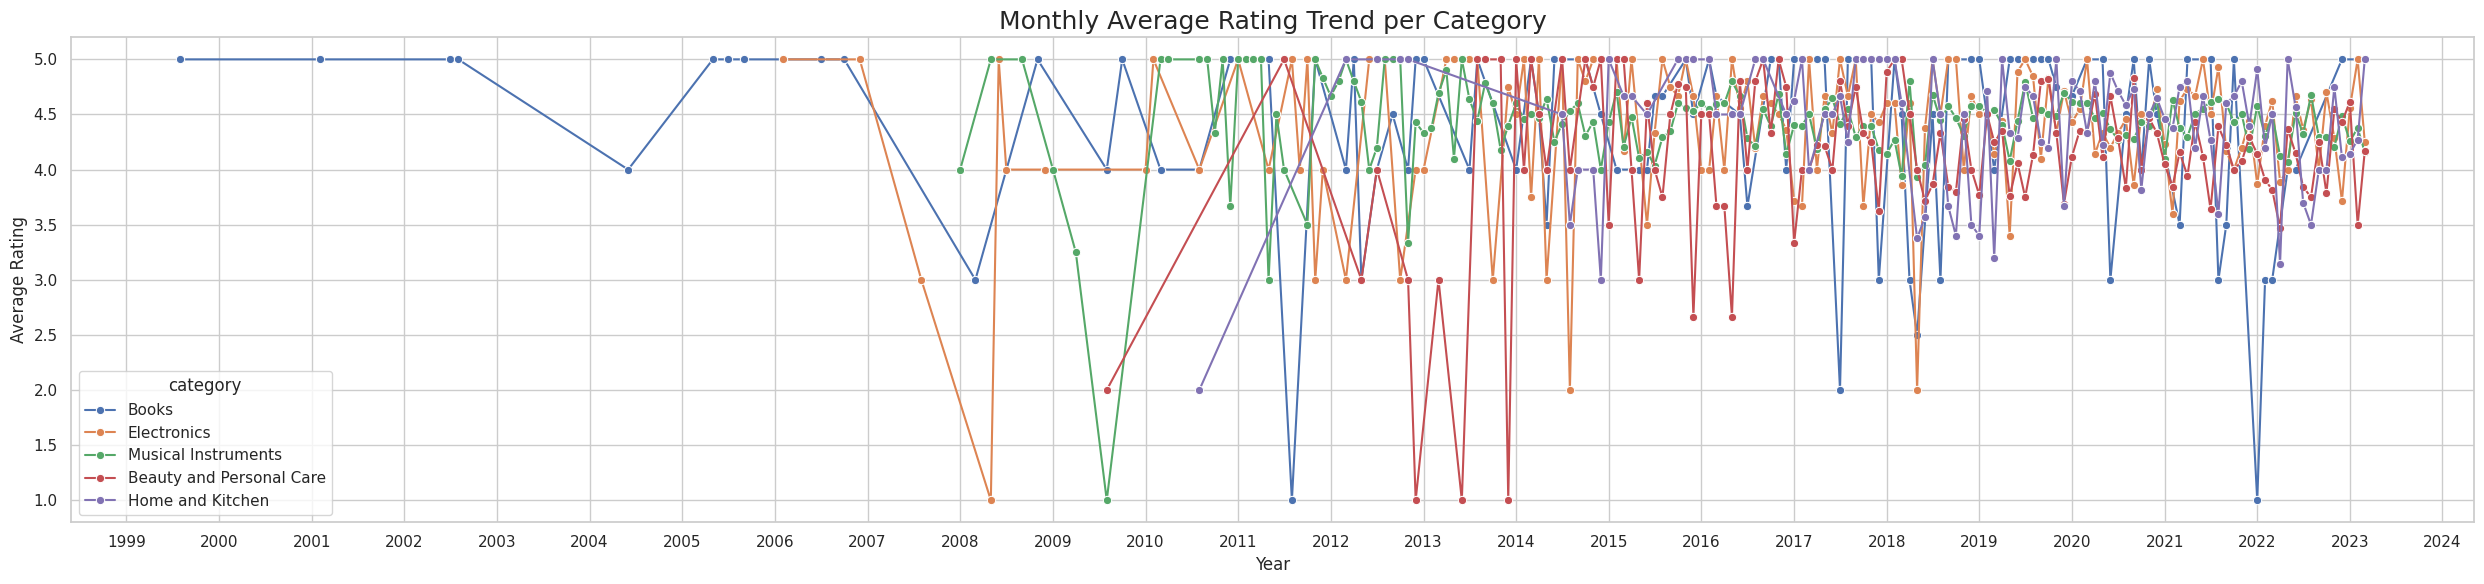

In [21]:
dfs = []
for category_name, (rev_csv, meta_csv) in categories_csv.items():
    df = pd.read_csv(rev_csv, usecols=["timestamp","rating"])
    df["category"]   = category_name
    df["datetime"]   = pd.to_datetime(df["timestamp"], unit="ms")
    df["year_month"] = df["datetime"].dt.to_period("M").dt.to_timestamp()
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

#calculate monthly average ratings for each category
monthly = (
    df_all
    .groupby(["year_month","category"], as_index=False)
    .agg(avg_rating=("rating","mean"))
)

#plotting
plt.figure(figsize=(25,6))
sns.lineplot(
    data=monthly,
    x="year_month",
    y="avg_rating",
    hue="category",
    marker="o"
)

#format axes
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.title("Monthly Average Rating Trend per Category", fontsize= 18)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Task 2:

In [22]:
%pip install vaderSentiment


Note: you may need to restart the kernel to use updated packages.


In [23]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def process_sentiment_scores(df_review, w1=0.6, w2=0.4):
    """Applies VADER + rating-based sentiment scoring to the reviews of the given category."""
    
    df_review["vader_score"] = df_review["text"].apply(lambda text: analyzer.polarity_scores(text)["compound"])
    df_review["normalized_rating"] = (df_review["rating"] - 1) / 4
    df_review["final_sentiment_score"] = (
        w1 * df_review["vader_score"] +
        w2 * df_review["normalized_rating"]
    )
    
    def label_sentiment(score):
        if score >= 0.5:
            return "positive"
        elif score <= 0.2:
            return "negative"
        else:
            return "neutral"
    
    df_review["sentiment_label"] = df_review["final_sentiment_score"].apply(label_sentiment)
    
    return df_review


In [24]:
# update the stored DataFrames in-place with sentiment
for i, df_review in enumerate(all_reviews_dfs):
    print(f"\n Applying sentiment to category index {i}...")

    df_review = process_sentiment_scores(df_review)

    # confirm sentiment is added
    print("Sample with sentiment:")
    print(df_review[["text", "rating", "vader_score", "final_sentiment_score", "sentiment_label"]].head(1))

    # store back in the list
    all_reviews_dfs[i] = df_review



 Applying sentiment to category index 0...
Sample with sentiment:
                                                 text  rating  vader_score  \
27  believe electrical boxes made especially fit r...     4.0       0.7902   

    final_sentiment_score sentiment_label  
27                0.77412        positive  

 Applying sentiment to category index 1...
Sample with sentiment:
                                                text  rating  vader_score  \
5  dont often leave negative feedback products re...     1.0       0.4539   

   final_sentiment_score sentiment_label  
5                0.27234         neutral  

 Applying sentiment to category index 2...
Sample with sentiment:
                                                  text  rating  vader_score  \
373  grandson turned 3 really loving stories read l...     5.0       0.8396   

     final_sentiment_score sentiment_label  
373                0.90376        positive  

 Applying sentiment to category index 3...
Sample with sentimen

In [25]:
# update the stored DataFrames in-place with sentiment
for i, df_review in enumerate(all_reviews_dfs):
    print(f"\nApplying sentiment to category index {i}...")

    df_review = process_sentiment_scores(df_review)

    # confirm sentiment is added
    print("Sample with sentiment:")
    print(df_review[["text", "rating", "vader_score", "final_sentiment_score", "sentiment_label"]].head(1))

    # store back in the list
    all_reviews_dfs[i] = df_review



Applying sentiment to category index 0...
Sample with sentiment:
                                                 text  rating  vader_score  \
27  believe electrical boxes made especially fit r...     4.0       0.7902   

    final_sentiment_score sentiment_label  
27                0.77412        positive  

Applying sentiment to category index 1...
Sample with sentiment:
                                                text  rating  vader_score  \
5  dont often leave negative feedback products re...     1.0       0.4539   

   final_sentiment_score sentiment_label  
5                0.27234         neutral  

Applying sentiment to category index 2...
Sample with sentiment:
                                                  text  rating  vader_score  \
373  grandson turned 3 really loving stories read l...     5.0       0.8396   

     final_sentiment_score sentiment_label  
373                0.90376        positive  

Applying sentiment to category index 3...
Sample with sentiment:
 

In [26]:
df_all_reviews = pd.concat(all_reviews_dfs, ignore_index=True)
print(f"\nFinal combined DataFrame shape: {df_all_reviews.shape}")
print("Final columns:", df_all_reviews.columns.tolist())



Final combined DataFrame shape: (6877, 10)
Final columns: ['rating', 'title', 'text', 'parent_asin', 'timestamp', 'user_id', 'vader_score', 'normalized_rating', 'final_sentiment_score', 'sentiment_label']


# **Part 2 Learning Tasks** 

In [27]:
selected_category = "Electronics" 

# the first DataFrame is for Electronics
electronics_meta_df = all_meta_dfs[0]
print(f"electronics_meta_df main_category: {electronics_meta_df['main_category'].iloc[0]}")



electronics_meta_df main_category: All Electronics


### Task 1

#### 1.

Pre-Processing on field description with stemming

In [28]:
electronics_meta_df['description'] = electronics_meta_df['description'].astype(str).apply(lambda text: process_text(text, stem=1))

Scale the numerical columns of electronics

In [29]:
def scale_features(df, columns_to_scale):
    """
    Scale the specified numerical columns in the DataFrame using MinMaxScaler.
    """
    scaler = MinMaxScaler()
    df_scaled = df.copy()

    for col in columns_to_scale:
        if col in df_scaled.columns:
            values = df_scaled[col].values.reshape(-1, 1)
            df_scaled[col] = scaler.fit_transform(values)

    return df_scaled


In [30]:
numeric_columns = ['average_rating', 'rating_number', 'price']
electronics_meta_df = scale_features(electronics_meta_df, numeric_columns)

#### 2.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

def create_feature_matrix(df, text_column='description', numeric_columns=None, max_features=1000):
    if numeric_columns is None:
        numeric_columns = []

    # drop rows with missing text
    df = df.dropna(subset=[text_column])

    # TF-IDF vectorization
    tfidf = TfidfVectorizer(max_features=max_features, stop_words='english')
    X_text = tfidf.fit_transform(df[text_column])

    # use scaled numeric features if available
    X_num = df[numeric_columns].values if numeric_columns else None

    # combine text and numeric features
    if X_num is not None:
        X_combined = hstack([X_text, X_num])
    else:
        X_combined = X_text

    return X_combined, tfidf.get_feature_names_out()


In [32]:
X_electronics, tfidf_features = create_feature_matrix(
    electronics_meta_df,
    text_column='description',
    numeric_columns=numeric_columns,
    max_features=1000  
)


print(f"Feature matrix shape: {X_electronics.shape}")


Feature matrix shape: (20000, 1003)


#### 3.

K	Inertia		Silhouette Score
----------------------------------------
2	11467.5		0.1073
3	11307.7		0.1226
4	11466.01		0.12
5	11328.86		0.1215
6	11203.38		0.1275
7	11127.37		0.1279
8	11059.81		0.1497
9	10970.55		0.1533
10	10915.63		0.1542


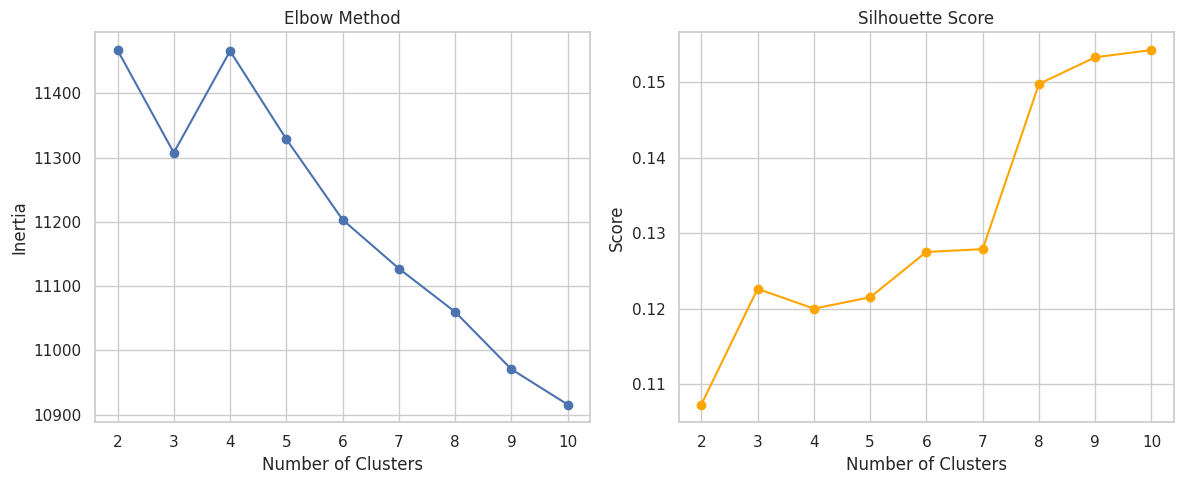

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
sil_scores = []
K_range = range(2, 11) 

print("K\tInertia\t\tSilhouette Score")
print("-" * 40)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_electronics)
    inertia.append(kmeans.inertia_)
    
    sil = silhouette_score(X_electronics, kmeans.labels_)
    sil_scores.append(sil)
    
    print(f"{k}\t{round(kmeans.inertia_, 2)}\t\t{round(sil, 4)}")


# plot elbow and silhouette scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K_range, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()



Visualize for the optimal K which is k = 10

In [34]:
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_electronics)

# attach cluster labels to original DataFrame
electronics_meta_df['cluster'] = cluster_labels


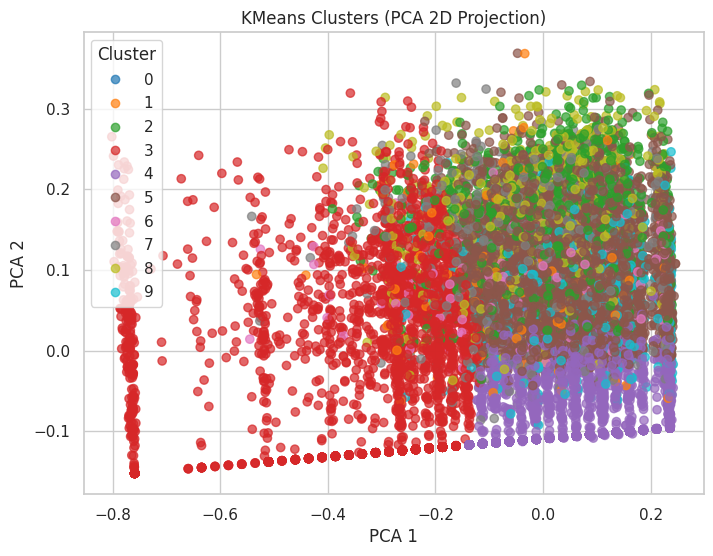

In [35]:
from sklearn.decomposition import PCA

# reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_electronics.toarray())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title("KMeans Clusters (PCA 2D Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


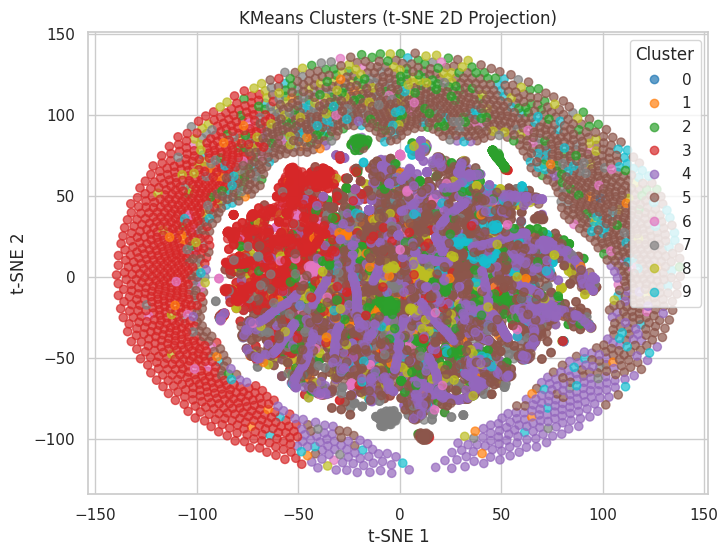

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_electronics.toarray())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title("KMeans Clusters (t-SNE 2D Projection)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


Print top product titles of each cluster

In [37]:
for c in range(optimal_k):
    print(f"\n--- Cluster {c} ---")
    cluster_df = electronics_meta_df[electronics_meta_df['cluster'] == c]
    print(cluster_df[['title', 'description', 'price']].head(5))



--- Cluster 0 ---
                                                  title  \
7490  Headphone Hanger, Headset Stand Gaming Accesso...   

                                            description  price  
7490  multius clutter desktop make bad mood annoy de...    0.0  

--- Cluster 1 ---
                                                 title  \
109  BORIYUAN iPad Mini 6 Keyboard Case 2021, 7 Col...   
183  GMYLE Compatible with MacBook Air Rubberized 1...   
219  4Keyboard Korean Japanese Hiragana Stickers fo...   
793  Ducky One 2 RGB TKL RGB LED Double Shot PBT Me...   
808  Mini Bluetooth Keyboard Wireless Keyboard - Ul...   

                                           description     price  
109  new ipad mini 6 keyboard case 2021 boriyuan 7 ...  0.002693  
183  case specif materi polycarbon materi polycarbo...  0.000000  
219  highqual sticker differ keyboard desktop lapto...  0.000308  
793  ducki one 2 rgb tkl rgb led doubl shot pbt mec...  0.000000  
808  troubl follow problem ▷a

#### Task 2
User-Based Collaborative Filtering:


In [38]:
from sklearn.metrics.pairwise import cosine_similarity
import random

# load review data
df = pd.read_csv("electronics_reviews_sample.csv")
df = df[['user_id', 'parent_asin', 'rating']].dropna()
sample_size = min(5000, len(df))
df = df.sample(n=sample_size, random_state=42)

# load meta data for titles
meta_df = pd.read_csv("electronics_meta_sample.csv")
asin_to_title = meta_df.set_index('parent_asin')['title'].to_dict()

# create user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='parent_asin', values='rating', fill_value=0)

# compute cosine similarity between users
user_sim = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_sim, index=user_item_matrix.index, columns=user_item_matrix.index)

# global store for predictions
user_cf_predictions_store = {}

# get top K similar users
def get_top_k_similar_users(target_user_id, k=5):
    sim_scores = user_sim_df.loc[target_user_id].drop(target_user_id)
    top_users = sim_scores.sort_values(ascending=False).head(k)
    return top_users

# predict unseen item ratings and store them
def predict_ratings_user_based(target_user_id, k=5):
    if target_user_id in user_cf_predictions_store:
        return user_cf_predictions_store[target_user_id]

    top_users = get_top_k_similar_users(target_user_id, k)
    user_ratings = user_item_matrix.loc[target_user_id]
    predicted_ratings = {}

    for item in user_item_matrix.columns:
        if user_ratings[item] == 0:
            weighted_sum = 0
            sim_sum = 0
            for other_user, sim_score in top_users.items():
                rating = user_item_matrix.loc[other_user, item]
                if rating > 0:
                    weighted_sum += sim_score * rating
                    sim_sum += sim_score
            if sim_sum > 0:
                predicted_ratings[item] = weighted_sum / sim_sum

    user_cf_predictions_store[target_user_id] = predicted_ratings
    return predicted_ratings

# recommend top-K products for a user, print titles
def recommend_top_k(target_user_id, k=5):
    predictions = predict_ratings_user_based(target_user_id, k)
    if not predictions:
        print(f"No recommendations available for user {target_user_id}.")
        return
    top_k = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:k]
    print(f"\nTop {k} recommendations for user {target_user_id}:\n")
    for asin, score in top_k:
        title = asin_to_title.get(asin, "Unknown Title")
        print(f"ASIN: {asin} | Predicted Rating: {score:.2f} | Title: {title}")




In [39]:

# run test for random user - might need a few tries to get 1 or more recommendations (small sample size)
random_user = random.choice(user_item_matrix.index.tolist())
recommend_top_k(random_user, k=5)


Top 5 recommendations for user AER6WLSJPBPNOZIQWVHQBVOKTNCA:

ASIN: B01H14SFRM | Predicted Rating: 5.00 | Title: HOLSEM 12 Outlets Surge Protector Power Strip with 3 Smart USB Charging Ports (5V/3.1A) and 6' Heavy Duty Extension Cord, White


Item-Based Collaborative Filtering:


In [40]:

# load review data
df = pd.read_csv("electronics_reviews_sample.csv")
df = df[['user_id', 'parent_asin', 'rating']].dropna()
sample_size = min(5000, len(df))
df = df.sample(n=sample_size, random_state=42)

# load meta data for titles
meta_df = pd.read_csv("electronics_meta_sample.csv")
asin_to_title = meta_df.set_index('parent_asin')['title'].to_dict()

# create user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='parent_asin', values='rating', fill_value=0)

# transpose for item-user matrix
item_user_matrix = user_item_matrix.T

# compute cosine similarity between items
item_sim = cosine_similarity(item_user_matrix)
item_sim_df = pd.DataFrame(item_sim, index=item_user_matrix.index, columns=item_user_matrix.index)

# global store for item-based predictions
item_cf_predictions_store = {}

# predict ratings for unseen items for a user, store results
def predict_ratings_item_based(user_id, k=5):
    if user_id in item_cf_predictions_store:
        return item_cf_predictions_store[user_id]

    user_ratings = user_item_matrix.loc[user_id]
    predictions = {}

    for item in user_item_matrix.columns:
        if user_ratings[item] == 0:
            # Find k most similar items rated by user
            similar_items = item_sim_df[item].drop(item)
            rated_items = user_ratings[user_ratings > 0].index
            similar_items = similar_items[rated_items].sort_values(ascending=False).head(k)

            weighted_sum = 0
            sim_sum = 0
            for sim_item, sim_score in similar_items.items():
                rating = user_ratings[sim_item]
                weighted_sum += sim_score * rating
                sim_sum += sim_score

            if sim_sum > 0:
                predictions[item] = weighted_sum / sim_sum

    item_cf_predictions_store[user_id] = predictions
    return predictions

# recommend top-K items for a user, print titles
def recommend_top_k_item_based(user_id, k=5):
    predictions = predict_ratings_item_based(user_id, k)
    if not predictions:
        print(f"No item-based recommendations available for user {user_id}.")
        return

    top_k = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:k]
    print(f"\nTop {k} item-based recommendations for user {user_id}:\n")
    for asin, score in top_k:
        title = asin_to_title.get(asin, "Unknown Title")
        print(f"ASIN: {asin} | Predicted Rating: {score:.2f} | Title: {title}")

# run for a random user
random_user = random.choice(user_item_matrix.index.tolist())
recommend_top_k_item_based(random_user, k=5)


No item-based recommendations available for user AHT3NNPRGAN65K6ESCJNKI7TPWPA.


In [41]:
# run for a random user
random_user = random.choice(user_item_matrix.index.tolist())
recommend_top_k_item_based(random_user, k=5)


Top 5 item-based recommendations for user AFJ74T4L5ZMC7PCNN4C567JNFWWA:

ASIN: B0089STM2C | Predicted Rating: 5.00 | Title: V7 Ultra Protective Sleeve for iPad mini and 7.9-Inch Tablets (TDM23BLK-OG-2N)
ASIN: B00AK31M3G | Predicted Rating: 5.00 | Title: Samsung micro SDXC UHS-1 Card PRO 64GB Class 10 for Galaxy Note 2 II
ASIN: B00E362W9O | Predicted Rating: 5.00 | Title: Sabrent Ultra Slim USB 2.0 to 2.5-Inch SATA External Aluminum Hard Drive Enclosure [Black] (EC-UK25)
ASIN: B00E3EVXVY | Predicted Rating: 5.00 | Title: Aleratec Headrest Mount Swivel Rear Seat Car Holder for Tablets from 7-10in
ASIN: B015ILEN80 | Predicted Rating: 5.00 | Title: Amazon Basics Circular Polarizer Camera Lens Filter - 67 mm


Content-Based Filtering:

In [44]:
from gensim.models import KeyedVectors
import gensim.downloader as api
# load Word2Vec vectors

print("Loading Word2Vec vectors...")

#google vector, very heavy on ram
#word_vectors = api.load("word2vec-google-news-300")
#word_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
#vector_dim = 300


#glove vector, lighter
word_vectors = api.load("glove-wiki-gigaword-50")
vector_dim = 50

# load metadata
meta_df = pd.read_csv("electronics_meta_sample.csv")
meta_df = meta_df[['parent_asin', 'title', 'description']].dropna()
meta_df['full_text'] = (meta_df['title'].fillna('') + ' ' + meta_df['description'].fillna('')).str.lower()

# convert text to averaged Word2Vec vectors
def vectorize_text(text):
    words = word_tokenize(text)
    vectors = [word_vectors[word] for word in words if word in word_vectors]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_dim)

print("Vectorizing product texts...")
meta_df['vector'] = meta_df['full_text'].apply(vectorize_text)

# product recommendation based on cosine similarity
def recommend_similar_products(asin, k=5):
    if asin not in meta_df['parent_asin'].values:
        print("ASIN not found.")
        return
    
    idx = meta_df.index[meta_df['parent_asin'] == asin][0]
    target_vector = meta_df.at[idx, 'vector'].reshape(1, -1)
    
    # compute cosine similarity
    all_vectors = np.vstack(meta_df['vector'].values)
    sim_scores = cosine_similarity(target_vector, all_vectors).flatten()
    
    # sort and print top K (excluding the product itself)
    sim_scores_with_idx = list(enumerate(sim_scores))
    sim_scores_with_idx = sorted(sim_scores_with_idx, key=lambda x: x[1], reverse=True)
    
    print(f"\nTop {k} similar products to ASIN: {asin} ({meta_df.at[idx, 'title']})\n")
    count = 0
    for i, score in sim_scores_with_idx:
        if i == idx:
            continue
        print(f"ASIN: {meta_df.at[i, 'parent_asin']} | Similarity: {score:.2f} | Title: {meta_df.at[i, 'title']}")
        count += 1
        if count == k:
            break


Loading Word2Vec vectors...
[==================================================] 100.0% 66.0/66.0MB downloaded
Vectorizing product texts...


In [45]:
# test on a random product
random_asin = random.choice(meta_df['parent_asin'].tolist())
recommend_similar_products(random_asin, k=5)


Top 5 similar products to ASIN: B081F6LBXZ (SM-T290 Glass Screen Replacement for Samsung Galaxy Tab A 8.0 2019(Wi-Fi) White)

ASIN: B07R6G2LWM | Similarity: 0.98 | Title: INFILAND Galaxy Tab A 10.1 2019 Keyboard Case Compatible with Samsung Galaxy Tab A 10.1 Inch Model SM-T510/SM-T515 2019 Release Tablet(3 Viewing Angle), Black
ASIN: B076F1KKGJ | Similarity: 0.98 | Title: JOTO Galaxy Tab A 8.0 2017 Screen Protector - Ultra HD Crystal Clear (Invisible) Screen Protector Film Guard for 8.0 inch Galaxy Tab A 2017 T380 T385, 3 Count
ASIN: B08B8HYQRT | Similarity: 0.98 | Title: JAOK Galaxy Tab A 10.1 2019 Keyboard Case, Removable Bluetooth Keyboard with Slim Protective Case Compatible with Samsung Galaxy TAB A T510 2019 (Rose Gold) (Beige)
ASIN: B07XRSW6YT | Similarity: 0.97 | Title: ProCase Galaxy Tab A 8.0 2019 Case T290 T295, Slim Light Cover Trifold Stand Hard Shell Folio Case for 8.0 inch Galaxy Tab A 2019 Without S Pen Model SM-T290 (Wi-Fi) SM-T295 (LTE) –Navy
ASIN: B00VJSJVP2 | Simil

In [46]:

# # run for 10 random ASINs and print recommendations
# random_asins = random.sample(meta_df['parent_asin'].tolist(), 10)
# for asin in random_asins:
#     recommend_similar_products(asin, k=5)


Hybrid Approach: Weighted Average:

In [47]:
def hybrid_recommendations(user_id, reference_asin, cf_weight=0.7, cbf_weight=0.3, k=5, return_results=False):
    """
    Hybrid recommendation combining CF and CBF scores with given weights.
    If return_results=True, returns a list of (ASIN, hybrid_score, title)
    """

    # Get CF predictions
    cf_preds_dict = predict_ratings_user_based(user_id, k=50)  # {asin: score}

    # Get CBF similarity scores
    if reference_asin not in meta_df['parent_asin'].values:
        print("Reference ASIN not found for CBF.")
        return []

    idx = meta_df.index[meta_df['parent_asin'] == reference_asin][0]
    target_vector = meta_df.at[idx, 'vector'].reshape(1, -1)
    all_vectors = np.vstack(meta_df['vector'].values)
    sim_scores = cosine_similarity(target_vector, all_vectors).flatten()
    asin_to_cbf_score = {meta_df.at[i, 'parent_asin']: sim for i, sim in enumerate(sim_scores)}

    # Combine CF + CBF
    hybrid_scores = {}
    for asin, cf_score in cf_preds_dict.items():
        cbf_score = asin_to_cbf_score.get(asin, 0)
        combined_score = cf_score * cf_weight + cbf_score * cbf_weight
        hybrid_scores[asin] = combined_score

    sorted_hybrid = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:k]

    if return_results:
        return [
            (
                asin,
                score,
                meta_df.loc[meta_df['parent_asin'] == asin, 'title'].values[0]
                if asin in meta_df['parent_asin'].values else "Unknown Title"
            )
            for asin, score in sorted_hybrid
        ]
    else:
        print(f"Hybrid Recommendations for user {user_id} based on reference ASIN {reference_asin}:\n")
        for asin, score in sorted_hybrid:
            title = meta_df.loc[meta_df['parent_asin'] == asin, 'title'].values[0]
            print(f"ASIN: {asin} | Hybrid Score: {score:.3f} | Title: {title}")

Testing with different weights

In [48]:

# define the weight combinations to test
weight_combinations = [
    (0.7, 0.3),
    (0.9, 0.1),
    (0.1, 0.9),
    (0.3, 0.7),
    (0.5, 0.5),
]

# pick one user and reference item
random_user = random.choice(user_item_matrix.index.tolist())
user_rated_items = user_item_matrix.loc[random_user]
liked_asins = user_rated_items[user_rated_items >= 4].index.tolist()

if not liked_asins:
    print(f"User {random_user} has no highly rated products to use as reference for hybrid.")
else:
    ref_asin = random.choice(liked_asins)

    results = []

    for cf_w, cbf_w in weight_combinations:
        print(f"Evaluating weights: CF={cf_w}, CBF={cbf_w}")
        #run hybrid recommendation
        hybrid_scores = hybrid_recommendations(random_user, ref_asin, cf_weight=cf_w, cbf_weight=cbf_w, k=5, return_results=True)

        # store in results
        for rank, (asin, score, title) in enumerate(hybrid_scores, start=1):
            results.append({
                "CF Weight": cf_w,
                "CBF Weight": cbf_w,
                "Rank": rank,
                "ASIN": asin,
                "Hybrid Score": round(score, 3),
                "Title": title
            })

    # display as table
    df_results = pd.DataFrame(results)
    print(f"\nHybrid Recommendations for User: {random_user}, Reference ASIN: {ref_asin}\n")
    display(df_results)


Evaluating weights: CF=0.7, CBF=0.3
Evaluating weights: CF=0.9, CBF=0.1
Evaluating weights: CF=0.1, CBF=0.9
Evaluating weights: CF=0.3, CBF=0.7
Evaluating weights: CF=0.5, CBF=0.5

Hybrid Recommendations for User: AFEMVUNGJXKV5HA463WSDY4I2K7Q, Reference ASIN: B0089STM2C



,CF Weight,CBF Weight,Rank,ASIN,Hybrid Score,Title
0,0.7,0.3,1,B00L6IUHXU,3.795,LensPen NLP-1CUP UltraPro Lens Cleaner (Silver)
1,0.7,0.3,2,B081GK53VN,3.795,WOWBOX Messenger Bag for Men 17.3 inch Canvas ...
2,0.7,0.3,3,B016XL20UM,3.794,ICOLOR Lovely Kitty 9.7 10 Inch Laptop Carryin...
3,0.7,0.3,4,B0BXZ4D1C2,3.792,GE Pro 3-Outlet Power Strip with Surge Protect...
4,0.7,0.3,5,B0C3W7KFG4,3.792,"JanSport Driver 8, Betsy Floral, One Size"
5,0.9,0.1,1,B00L6IUHXU,4.598,LensPen NLP-1CUP UltraPro Lens Cleaner (Silver)
6,0.9,0.1,2,B081GK53VN,4.598,WOWBOX Messenger Bag for Men 17.3 inch Canvas ...
7,0.9,0.1,3,B016XL20UM,4.598,ICOLOR Lovely Kitty 9.7 10 Inch Laptop Carryin...
8,0.9,0.1,4,B0BXZ4D1C2,4.597,GE Pro 3-Outlet Power Strip with Surge Protect...
9,0.9,0.1,5,B0C3W7KFG4,4.597,"JanSport Driver 8, Betsy Floral, One Size"


Collaborative Filtering: 
Pros: Includes what other users liked, even though the descriptions might not show a similarity or the product might not have a description.
Cons: It doesn't work if the user is new or hasn't reviewed some product.
    Can show bias towards popular items.

Content-Based Filtering:
Pros: Works quite good even if very few users have interacted with the products
      Customized recommendations based on the product features the customer liked.

Cons: Limited by the metadata and the quality of the descriptions
      Does not take into account social trends.



### Task 3

Preprocessing and Feature Extraction

In [51]:
# Automatically detect the dimension from the loaded model
embedding_dim = word_vectors.vector_size 

def get_word2vec_vector(text, model, dim=embedding_dim):
    tokens = text.split()
    # Use the model's actual size to ensure consistency
    actual_dim = model.vector_size
    vectors = [model[word] for word in tokens if word in model]
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # Fallback must match the model's dimension
        return np.zeros(actual_dim)

In [52]:

from sklearn.model_selection import train_test_split


# load dataset
df = pd.read_csv("electronics_reviews_sample.csv", usecols=["text", "rating"])

# map ratings to labels: 0=negative (<=2), 1=neutral (=3), 2=positive (>=4)
df["label"] = df["rating"].apply(lambda r: 0 if r <= 2 else 1 if r == 3 else 2)

# apply preprocessing with stemming 
df["processed_text"] = df["text"].apply(lambda t: process_text(str(t), stem=1))



def get_word2vec_vector(text, model, dim=embedding_dim):
    tokens = text.split()
    vectors = [model[word] for word in tokens if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

# create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df["processed_text"])

# create Word2Vec embedding features
X_word2vec = np.vstack([get_word2vec_vector(text, word_vectors) for text in df["processed_text"]])

# create numerical feature: length of review (in tokens)
X_num = df["processed_text"].apply(lambda x: len(x.split())).values.reshape(-1, 1)

# combine Word2Vec embeddings and numerical feature
X_word2vec_num = np.hstack([X_word2vec, X_num])

# labels
y = df["label"].values

print("Features and labels now prepared")


Features and labels now prepared


In [53]:

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, make_scorer
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression



# first split dataset into train and test 
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, stratify=y, random_state=42)
X_train_w2v, X_test_w2v, _, _ = train_test_split(
    X_word2vec, y, test_size=0.2, stratify=y, random_state=42)
X_train_w2v_num, X_test_w2v_num, _, _ = train_test_split(
    X_word2vec_num, y, test_size=0.2, stratify=y, random_state=42)

# define models and feature sets
models = {
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
}

features_train = {
    "TF-IDF": X_train_tfidf,
    "Word2Vec": X_train_w2v,
    "Word2Vec+Num": X_train_w2v_num,
}

features_test = {
    "TF-IDF": X_test_tfidf,
    "Word2Vec": X_test_w2v,
    "Word2Vec+Num": X_test_w2v_num,
}

def valid_model_feature_combination(model_name, feature_name):
    # multinomialNB only works with TF-IDF features (non-negative)
    if model_name == "Naive Bayes" and feature_name != "TF-IDF":
        return False
    return True

# train on train set, evaluate on test set 

print("Single Train/Test Split Evaluation")
test_results = []
for feat_name in features_train:
    for model_name, model in models.items():
        if not valid_model_feature_combination(model_name, feat_name):
            continue

        X_tr = features_train[feat_name]
        X_te = features_test[feat_name]

        # convert sparse to dense if needed and model requires it
        if hasattr(X_tr, "toarray") and not isinstance(model, MultinomialNB):
            X_tr_eval = X_tr.toarray()
            X_te_eval = X_te.toarray()
        else:
            X_tr_eval = X_tr
            X_te_eval = X_te

        model.fit(X_tr_eval, y_train)
        y_pred = model.predict(X_te_eval)

        test_results.append({
            "Model": model_name,
            "Features": feat_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="macro", zero_division=0),
            "Recall": recall_score(y_test, y_pred, average="macro", zero_division=0),
            "F1-Score": f1_score(y_test, y_pred, average="macro", zero_division=0),
        })

test_results_df = pd.DataFrame(test_results)
print(test_results_df)



Single Train/Test Split Evaluation
                 Model      Features  Accuracy  Precision    Recall  F1-Score
0          Naive Bayes        TF-IDF  0.844595   0.281532  0.333333  0.305250
1                  KNN        TF-IDF  0.844595   0.281532  0.333333  0.305250
2        Random Forest        TF-IDF  0.844595   0.281532  0.333333  0.305250
3  Logistic Regression        TF-IDF  0.864865   0.530952  0.447048  0.468164
4                  KNN      Word2Vec  0.770270   0.281481  0.304000  0.292308
5        Random Forest      Word2Vec  0.844595   0.281532  0.333333  0.305250
6  Logistic Regression      Word2Vec  0.581081   0.383748  0.411704  0.357595
7                  KNN  Word2Vec+Num  0.831081   0.280822  0.328000  0.302583
8        Random Forest  Word2Vec+Num  0.844595   0.281532  0.333333  0.305250
9  Logistic Regression  Word2Vec+Num  0.560811   0.381540  0.403704  0.350006


In [54]:


print("\n10-Fold Cross-Validation on Training Set")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, average="macro", zero_division=0),
    "recall": make_scorer(recall_score, average="macro", zero_division=0),
    "f1": make_scorer(f1_score, average="macro", zero_division=0),
}

cv_results = []
for feat_name, X in features_train.items():
    for model_name, model in models.items():
        if not valid_model_feature_combination(model_name, feat_name):
            continue

        if hasattr(X, "toarray") and not isinstance(model, MultinomialNB):
            X_eval = X.toarray()
        else:
            X_eval = X

        scores = cross_validate(model, X_eval, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        cv_results.append({
            "Model": model_name,
            "Features": feat_name,
            "Accuracy": np.mean(scores["test_accuracy"]),
            "Precision": np.mean(scores["test_precision"]),
            "Recall": np.mean(scores["test_recall"]),
            "F1-Score": np.mean(scores["test_f1"]),
        })

cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df)




10-Fold Cross-Validation on Training Set
                 Model      Features  Accuracy  Precision    Recall  F1-Score
0          Naive Bayes        TF-IDF  0.846299   0.282100  0.333333  0.305582
1                  KNN        TF-IDF  0.846299   0.282100  0.333333  0.305582
2        Random Forest        TF-IDF  0.847994   0.315920  0.338889  0.315389
3  Logistic Regression        TF-IDF  0.844520   0.517716  0.408458  0.424226
4                  KNN      Word2Vec  0.831130   0.480884  0.396791  0.409385
5        Random Forest      Word2Vec  0.846299   0.282100  0.333333  0.305582
6  Logistic Regression      Word2Vec  0.574294   0.395924  0.466065  0.375442
7                  KNN  Word2Vec+Num  0.824379   0.315674  0.330719  0.312807
8        Random Forest  Word2Vec+Num  0.846299   0.282100  0.333333  0.305582
9  Logistic Regression  Word2Vec+Num  0.567514   0.397178  0.471092  0.375427


In [56]:


# load dataset
df = pd.read_csv("electronics_reviews_sample.csv", usecols=["text", "rating"])
df["label"] = df["rating"].apply(lambda r: 0 if r <= 2 else 1 if r == 3 else 2)
df["processed_text"] = df["text"].apply(lambda t: process_text(str(t), stem=1))

# 1. Detect the actual size of the loaded model
embedding_dim = word_vectors.vector_size 
print(f"Detected model dimension: {embedding_dim}")

# 2. Update the function to use the model's native size
def get_word2vec_vector(text, model):
    # We use model.vector_size directly to prevent mismatches
    dim = model.vector_size
    tokens = text.split()
    vectors = [model[word] for word in tokens if word in model]
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

# 3. Create feature sets (dim is no longer passed as an argument)
X_word2vec = np.vstack([get_word2vec_vector(text, word_vectors) for text in df["processed_text"]])

# train-test split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)
X_train_w2v, X_test_w2v, _, _ = train_test_split(X_word2vec, y, test_size=0.2, stratify=y, random_state=42)
X_train_w2v_num, X_test_w2v_num, _, _ = train_test_split(X_word2vec_num, y, test_size=0.2, stratify=y, random_state=42)

# models and features
final_models = {
    "Naive Bayes (TF-IDF)": (MultinomialNB(), X_train_tfidf, X_test_tfidf),
    "KNN (Word2Vec)": (KNeighborsClassifier(n_neighbors=5), X_train_w2v, X_test_w2v),
    "Random Forest (Word2Vec)": (RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42), X_train_w2v, X_test_w2v),
    "LogReg (Word2Vec+Num)": (LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42), X_train_w2v_num, X_test_w2v_num),
}

# evaluation
test_results = []
for name, (model, X_tr, X_te) in final_models.items():
    # convert sparse to dense if necessary
    X_tr_eval = X_tr.toarray() if hasattr(X_tr, "toarray") and not isinstance(model, MultinomialNB) else X_tr
    X_te_eval = X_te.toarray() if hasattr(X_te, "toarray") and not isinstance(model, MultinomialNB) else X_te
    
    model.fit(X_tr_eval, y_train)
    y_pred = model.predict(X_te_eval)

    test_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "Recall": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, average="macro", zero_division=0),
    })

# create and show final test evaluation table
test_df = pd.DataFrame(test_results)
test_df.to_csv("test_results_only.csv", index=False)
test_df


Detected model dimension: 50


,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes (TF-IDF),0.844595,0.281532,0.333333,0.305250
1,KNN (Word2Vec),0.770270,0.281481,0.304000,0.292308
2,Random Forest (Word2Vec),0.844595,0.281532,0.333333,0.305250
3,LogReg (Word2Vec+Num),0.560811,0.381540,0.403704,0.350006
